# Sample Analytics for the TNC trip data

All trips, starting November 2018, reported by Transportation Network Providers (sometimes called rideshare companies) to the City of Chicago as part of routine reporting required by ordinance.
Census Tracts are suppressed in some cases, and times are rounded to the nearest 15 minutes. Fares are rounded to the nearest \\$2.50 and tips are rounded to the nearest \\$1.00.

The files are saved in the form of python pickle file format which was downloaded from [here](https://data.cityofchicago.org/Transportation/Transportation-Network-Providers-Trips/m6dm-c72p). Present analysis only contains the subset of dataset from 10th March 2019 to 16th March 2019, i.e. one full week of the dataset.


In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

In [34]:
infile = open("one_week.pkl", 'rb')

#infile = "../../../../tnc/Trips/trip_test.pkl"
df = pickle.load(infile)
infile.close()

A sample investigation into the data provides the following columns available which could be used for the further analysis. 

In [35]:
df.head()

,Trip ID,Trip Start Timestamp,Trip End Timestamp,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Trip Total,Shared Trip Authorized,Trips Pooled,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude
16,5fa0cc351644ebdfe312bb8c893fd9dce4c8ed75,2019-03-12 14:15:00,2019-03-12 14:30:00,1.5,1.703108e+10,1.703108e+10,9.550000,False,1,41.892040,-87.631866,41.899155,-87.626213
35,5fa0d65d6505d6a32c8043c87fcd1e57bd6a038c,2019-03-16 12:30:00,2019-03-16 12:45:00,7.1,NaN,NaN,20.049999,False,1,41.946510,-87.806023,41.980263,-87.913628
42,5fa0da6a5df7c4da455a4028cbbc48aad8f70329,2019-03-11 07:00:00,2019-03-11 07:15:00,2.1,1.703108e+10,1.703107e+10,7.550000,False,1,41.900265,-87.632111,41.930580,-87.642204
48,5fa0de3f6b2428a658e25364437765487acbae7a,2019-03-16 21:15:00,2019-03-16 21:30:00,5.7,NaN,NaN,10.000000,True,1,41.740204,-87.615967,41.792358,-87.617935
56,5fa0e2081d4481c4cbd826e6b02c5fee49c5a613,2019-03-15 12:30:00,2019-03-15 12:45:00,11.3,NaN,NaN,27.559999,False,1,NaN,NaN,41.980263,-87.913628


In [36]:
df = df.dropna(subset=['Pickup Centroid Latitude', 'Pickup Centroid Longitude', 'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude'])
df['pooled'] = df['Trips Pooled'].apply(lambda x: 'Yes' if x>1 else 'No')
df['trip_dur'] = df['Trip End Timestamp'] - df['Trip Start Timestamp']
df['trip_dur'] = df['trip_dur']/np.timedelta64(1, 'm')

Let's do some basic exploratory analysis of the dataset. Following are the few pointers that we can see. 
1. Percentage of trips pooled 
2. Percentage of the trips that are authorized for the shared trips 
3. Distribution of the trip distance 
4. Distribution of the total trip cost

In [37]:
df['Shared Trip Authorized'].value_counts()/len(df)

False    0.747235
True     0.252765
Name: Shared Trip Authorized, dtype: float64

Aroud 74.72% of the trips are non-authorized for the shared trips which means that majority of the TNCs request are for the non-shared trips. The table below shows that around 7.3% of the trips which were authorised for pooling were not able to be matched.

In [38]:
pd.crosstab(df['pooled'], df['Shared Trip Authorized']).apply(lambda r: r/r.sum(), axis=1)

Shared Trip Authorized,False,True
pooled,,
No,0.926805,0.073195
Yes,0.000289,0.999711


In [39]:
df.describe()

,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Trip Total,Trips Pooled,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude,trip_dur
count,2.108411e+06,1.685521e+06,1.685521e+06,2.108411e+06,2.108411e+06,2.108411e+06,2.108411e+06,2.108411e+06,2.108411e+06,2.108411e+06
mean,4.677828e+00,1.714798e+10,1.714798e+10,1.287491e+01,1.379657e+00,4.077803e+01,-8.577094e+01,4.077871e+01,-8.577098e+01,1.658253e+01
std,4.494465e+00,1.163297e+08,1.163284e+08,8.355762e+00,9.361253e-01,1.114952e+00,1.890870e+00,1.115208e+00,1.891345e+00,1.307915e+01
min,0.000000e+00,1.703101e+10,1.703101e+10,7.200000e-01,1.000000e+00,4.165022e+01,-8.791363e+01,4.165022e+01,-8.791363e+01,0.000000e+00
25%,1.600000e+00,1.703108e+10,1.703108e+10,7.550000e+00,1.000000e+00,4.187741e+01,-8.767531e+01,4.187867e+01,-8.767509e+01,1.500000e+01
50%,3.200000e+00,1.703124e+10,1.703124e+10,1.005000e+01,1.000000e+00,4.189322e+01,-8.765131e+01,4.189266e+01,-8.764991e+01,1.500000e+01
75%,6.000000e+00,1.703183e+10,1.703183e+10,1.505000e+01,1.000000e+00,4.192862e+01,-8.763171e+01,4.192862e+01,-8.763171e+01,1.500000e+01
max,2.459000e+02,1.703198e+10,1.703198e+10,4.028500e+02,1.700000e+01,4.202122e+01,-8.753072e+01,4.202122e+01,-8.752995e+01,7.050000e+02


The summary analysis shows that an *average* trip length is of **4.67 miles** annd the total average cost of the trips is **\\$12.87** and average duration of the trip is **16.58 minutes**.

[Text(0,0.5,'Frequency'), Text(0.5,1,'Frequency Histogram')]

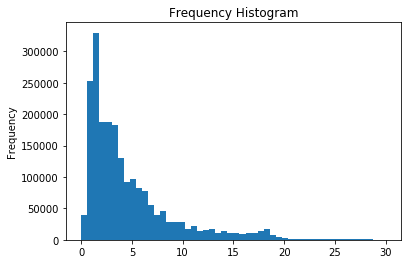

In [14]:
#plot histogram of trip distance 
plt.hist(df['Trip Miles'], bins= 50, range = [0, 30])
plt.gca().set(title='Frequency Histogram', ylabel = 'Frequency')

[Text(0,0.5,'Frequency'), Text(0.5,1,'Frequency Histogram')]

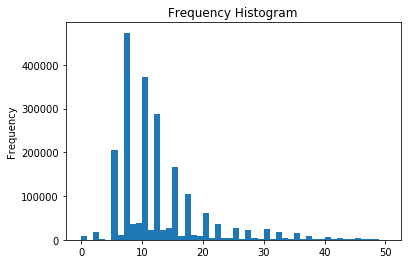

In [15]:
#plot histogram of trip fare 
plt.hist(df['Trip Total'], bins= 50, range = [0, 50])
plt.gca().set(title='Frequency Histogram', ylabel = 'Frequency')

In addition to these, the AM trip patterns for one day with source and destination could be visualized. An open source library [kepler.gl](https://github.com/keplergl/kepler.gl) has been used to plot the following pictures. 


![title](Visuals\Source Destination AM Maps.png)

Similary another example could be investigating the origin of small trips (less than 3 miles) in the citywide hexabin polygons where the height of the bins represent the number of the trips taken in that area. 

![title](Visuals\Short Trips.png)